<a href="https://colab.research.google.com/github/kfcgenius/Game/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9D%D0%B5%D1%87%D0%B5%D1%82%D0%BA%D0%B0%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%BE%D1%86%D0%B5%D0%BD%D0%BE%D0%BA_%D0%B8%D0%BD%D0%B2%D0%B5%D1%81%D1%82_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%BE%D0%B2%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
!pip install fuzzy-c-means

In [ ]:
#Библиотека для кластеризации
from fcmeans import FCM

Загружаем данные

In [ ]:
df = pd.read_excel("Данные экспертов.xlsx")
df = df.set_index("Номер проекта")

Смотрим первые строки

In [ ]:
score_columns = df.columns
df.head()

,А1,А2,А3,А4,А5,А6,А7
Номер проекта,,,,,,,
1,0.0343,0.0284,0.0420,0.0274,0.0179,0.0053,0.0081
2,0.0948,0.1360,0.0188,0.0057,0.0080,0.0025,0.0036
3,0.2028,0.0635,0.0900,0.0123,0.0037,0.0253,0.0174
4,0.0198,0.0133,0.0088,0.0587,0.0382,0.0118,0.0017
5,0.1890,0.8658,0.2682,0.4698,0.6174,0.1611,0.0268


Описательная статистика

In [ ]:
df.describe()

,А1,А2,А3,А4,А5,А6,А7
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.479444,0.371322,0.336894,0.428250,0.395358,0.387898,0.033988
std,0.281644,0.243847,0.262873,0.294204,0.279731,0.270552,0.026007
min,0.019800,0.013300,0.002700,0.005700,0.003700,0.001800,0.000300
25%,0.205200,0.177525,0.085950,0.133425,0.138825,0.151650,0.008950
50%,0.549900,0.302850,0.293400,0.403650,0.366750,0.357750,0.029350
75%,0.742050,0.581175,0.497250,0.694575,0.650475,0.606825,0.049700
max,0.899100,0.865800,0.896400,0.892800,0.858600,0.895500,0.089600


Обучение модели кластеризации

Параметры для воспроизведения
- m = 1.2 - коэффициент размытости
- c = 3 - число кластеров
- e = 1e-06 - порог ошибки. Когда изменения центров кластеров становятся меньше этого значения, обучение прекращается.
- max_iter - максимальное число итераций
- random_state - чтобы эксперимент воспроизводился с одним и тем же результатом на разных компьютерах

In [ ]:
m = 1.2
c = 3
e = 1e-06
max_iter = 200
random_state = 0


Создаём объект модели Fuzzy C-Means, но пока он не обучен.
Он “знает”, сколько кластеров искать и с какой степенью размытости.

In [ ]:
my_fcm = FCM(n_clusters=c, m=m, error=e, max_iter=max_iter, random_state=random_state)

Метод fit() запускает процесс обучения:

- случайно инициализируются центры кластеров;

- итеративно обновляются центры и матрица принадлежностей (membership);

- повторяется, пока изменение не станет меньше error или не достигнут max_iter.

В результате модель “понимает”, где находятся типичные центры проектов (например, успешные, средние, слабые).

In [ ]:
my_fcm.fit(df[score_columns].values)

In [ ]:
#Получаем центры кластеров
centers = my_fcm.centers
#Получаем метки кластера для каждого проекта
labels = my_fcm.predict(df[score_columns].values)
#Получаем расстояния каждого проекта до каждого кластера
distance_to_centers = my_fcm.soft_predict(df[score_columns].values)

Снижаем пространство из 6-и мерного в 2-х мерное, для отображения на плоскости

In [ ]:
#Создаем модель для снижения пространственной размерности данных. Оставляем 2 главные компоненты, т.е. проектируем 6-мерные данные в 2D
pca = PCA(2, random_state=42)
#Обучение. Как наилучшим образом повернуть исходное 6D-пространство, чтобы первые 2 направления (оси) содержали максимум информации (вариации между проектами).
pca.fit(df[score_columns].values)
#Снижаем 6-и мерное пространство оценок до 2-х мерного
data_for_visual = pca.transform(df[score_columns].values)
#Снижаем 6-и мерное пространство центров кластеров до 2-х мерного
centers_for_visual = pca.transform(centers)
#Матрица принадлежностей или “расстояний” каждого проекта к 3 центрам кластеров: k1 — степень принадлежности к кластеру 1,
#k2 — к кластеру 2, k3 — к кластеру 3.
df[['k1', 'k2', 'k3']] = distance_to_centers
#Добавляем каждому проекту его метку кластера
df['labels'] = labels
#Добавляем набор данных столбцы с новыми 2-х мерными координатами для отображения каждого проекта, как точки
df[['x', 'y']] = data_for_visual

#Создаём отдельную таблицу с координатами центров, для дальнейшего отображения на плоскости"""
result_center = pd.DataFrame(centers_for_visual, columns=['x', 'y'])

df.head()

,А1,А2,А3,А4,А5,А6,А7,k1,k2,k3,labels,x,y
Номер проекта,,,,,,,,,,,,,
1,0.0343,0.0284,0.0420,0.0274,0.0179,0.0053,0.0081,0.005536,0.002526,0.991939,2,-0.779487,-0.418935
2,0.0948,0.1360,0.0188,0.0057,0.0080,0.0025,0.0036,0.004281,0.001564,0.994155,2,-0.763440,-0.405785
3,0.2028,0.0635,0.0900,0.0123,0.0037,0.0253,0.0174,0.005748,0.001720,0.992532,2,-0.696962,-0.422577
4,0.0198,0.0133,0.0088,0.0587,0.0382,0.0118,0.0017,0.006915,0.003650,0.989435,2,-0.756380,-0.434259
5,0.1890,0.8658,0.2682,0.4698,0.6174,0.1611,0.0268,0.132635,0.287420,0.579946,2,-0.128612,0.371364


Проводим анализ результатов

k1 - принят, k2 - на доработку, k3 - отклонен

Распределение числа проектов по кластерам


In [ ]:
df.labels.value_counts()

,count
labels,
1,21
0,15
2,14


<Axes: ylabel='labels'>

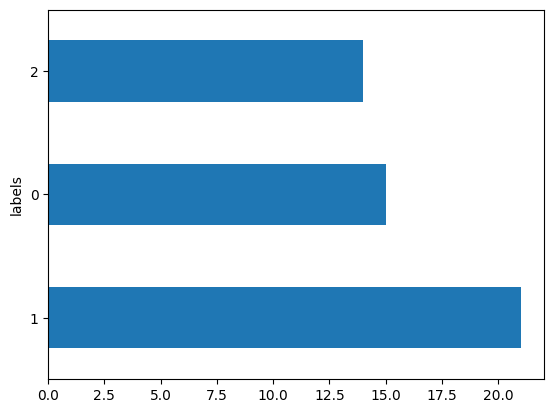

In [ ]:
df.labels.value_counts().plot(kind='barh')

Посмотрим, на сколько отличаются средние оценки по проектам в разрезе кластеров

<Axes: xlabel='value', ylabel='variable'>

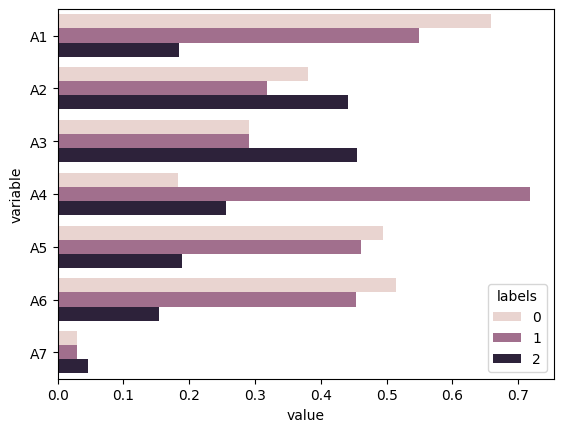

In [ ]:
for_plot = df[[col for col in df.columns if 'А' in col] + ['labels']].melt(id_vars=['labels'])
gr_data = for_plot.groupby(['labels', 'variable'], as_index=False)["value"].mean()
sns.barplot(data=gr_data, x='value', y='variable', hue='labels')

Визуализируем кластера проектов на плоскости с нанесением центров кластеров

<module 'seaborn' from '/usr/local/lib/python3.12/dist-packages/seaborn/__init__.py'>

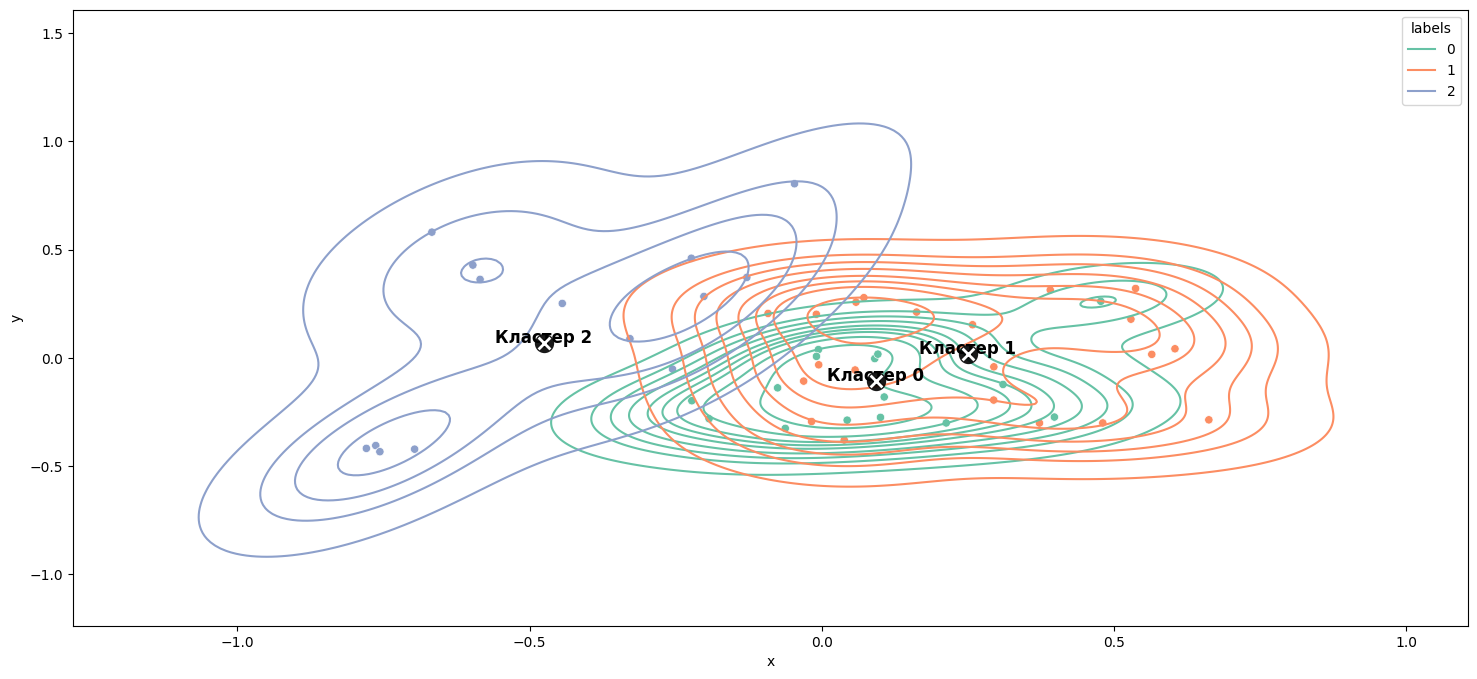

In [ ]:
plt.figure(figsize=(18,8))

def plot_centroids(centroids, circle_color='k', cross_color='w'):
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

sns.scatterplot(data=df, x='x', y='y', hue='labels', palette='Set2', sizes=7) #облака из точек, одна точка - один проект, устанавливаем цветовую палитру
plot_centroids(result_center.values) #Добавляем центры кластеров на тот же график
sns.kdeplot(data=df, x='x', y='y', hue='labels', palette='Set2')
for i, (x, y) in enumerate(result_center.values):
    plt.text(x, y, f'Кластер {i}', fontsize=12, weight='bold', color='black', ha='center')
sns

Таким образом выделено три области. Они отличаются, но частично перекрываются:
это говорит о том, что проекты не образуют полностью отделённые «жёсткие» группы — часть из них находится в переходной зоне между кластерами.
Это естественно для метода нечёткой кластеризации: некоторые проекты имеют промежуточные оценки, и модель отражает это неуверенностью.

Синий кластер — отдельная группа, удалённая от остальных.
Эти проекты, вероятно, имеют особо отличающиеся характеристики (низкие баллы) — их можно интерпретировать как отклонённые.

Правые два кластера (оранжевый и зелёный) расположены близко друг к другу.
Они отражают схожие, но не идентичные оценки: один, соответствует проектам на доработку, а другой — принятым.

Центры кластеров расположены упорядоченно слева направо, что может означать последовательный рост интегральной оценки проекта — от слабых к сильным.